In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lazypredict.Supervised import LazyRegressor

# Load the dataset
df = pd.read_csv('event_sponsorship_roi_dataset.csv')

# Preprocess the data
df['Avg_Sponsor_Cost'] = df.apply(lambda row: np.mean([float(cost) for cost in row['Sponsor Costs'].split('|')]), axis=1)

# Create binary columns for each sponsorship type
sponsor_types = ["Media Sponsorship", "Food Stalls", "Philanthropy", "Merchandise", "In Kind", "Influencer", "Financial"]
for sponsor_type in sponsor_types:
    df[f'Has_{sponsor_type}'] = df['Sponsor Types'].apply(lambda x: int(sponsor_type in x))

event_types = ["Festivals and fairs", "Virtual event", "Conferences and seminars", "Sports events", "Community and charity events", "Entertainment and media events"]
for event_type in event_types:
    df[f'Is_{event_type}'] = df['Event Type'].apply(lambda x: int(event_type in x))

# df = pd.get_dummies(df, columns=['Event Type'], dtype=int)
# Prepare features and target
X = df[['Avg_Sponsor_Cost', 'Expected Footfall', 'Budget'] + 
       [f'Is_{event_type}' for event_type in event_types] +
       [f'Has_{sponsor_type}' for sponsor_type in sponsor_types]]
y = df['Total Revenue']

# Split the data
X.head()

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and run LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print("Model Comparison:")
print(models)

# # Print actual range of ROI in the dataset
# print(f"\nActual ROI range in the dataset:")
# print(f"Minimum ROI: {y.min():.2f}%")
# print(f"Maximum ROI: {y.max():.2f}%")
# print(f"Mean ROI: {y.mean():.2f}%")

# # Get the best performing model
# best_model_name = models.index[0]
# best_model_r2 = models.iloc[0]['R-Squared']
# print(f"\nBest performing model: {best_model_name}")
# print(f"Best model R-squared score: {best_model_r2:.4f}")


100%|██████████| 42/42 [00:49<00:00,  1.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 15
[LightGBM] [Info] Start training from score 176983.739909
Model Comparison:
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HuberRegressor                               0.92       0.92  35085.27   
PassiveAggressiveRegressor                   0.92       0.92  35085.58   
LassoLarsIC                                  0.92       0.92  35106.84   
LassoLarsCV                                  0.92       0.92  35108.01   
LarsCV                                       0.92       0.92  35108.01   
LassoCV                                      0.92      

In [10]:
import pandas as pd
import statistics
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [11]:
r1=LinearRegression()
r2=Lasso()
r3=Ridge()
r4=ElasticNet()
r5=SVR()
r6=DecisionTreeRegressor()
r7=RandomForestRegressor()
reg=[r1,r2,r3,r4,r5,r6,r7]
names=['LR','LASSO','RIDGE','EL','SVR','DTR','RFR']
mse={}
r2s={}
t={}
import time
from sklearn.metrics import mean_squared_error,r2_score

for model,name in zip(reg,names):
  t1=time.time()
  model.fit(X_train_scaled,y_train)
  y_pred=model.predict(X_test_scaled)
  t2=time.time()
  mse[name]=mean_squared_error(y_test,y_pred)
  r2s[name]=r2_score(y_test,y_pred)
  t[name]=t2-t1

for i,j in r2s.items():
  print(i,':',j*100)

LR : 92.03136653696045
LASSO : 92.03132371113234
RIDGE : 92.00762787228383
EL : 29.864347238266
SVR : -2.924269090212328
DTR : 83.48125286452182
RFR : 91.30145037083129


In [12]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Initialize CatBoost
catboost_model = CatBoostRegressor(verbose=0, random_seed=42)

# Fit the model
catboost_model.fit(X_train, y_train)

# Predict
y_pred = catboost_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CatBoost R-Squared: {r2:.4f}")
print(f"CatBoost RMSE: {rmse:.2f}")


CatBoost R-Squared: 0.9142
CatBoost RMSE: 36433.16


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Assuming your DataFrame is named df
# Define your feature columns and target column
feature_cols = []
for col in X:
    feature_cols.append(col)
target_col = 'Total Revenue'

# Separate the features and target
X = df[feature_cols]
y = df[target_col]

# Preprocessing for numerical data: impute missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, feature_cols)
    ])

# Define the model pipeline
estimators = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]

stacking_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', StackingRegressor(
        estimators=estimators,
        final_estimator=RidgeCV()
    ))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
stacking_model.fit(X_train, y_train)

# Predict
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate the model
r2_stacking = r2_score(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))

print(f"Stacking Regressor R-Squared: {r2_stacking:.4f}")
print(f"Stacking Regressor RMSE: {rmse_stacking:.2f}")


Stacking Regressor R-Squared: 0.9194
Stacking Regressor RMSE: 35309.33


In [16]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Define the model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

# Grid search
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search_lgb.fit(X_train, y_train)

# Best model
best_lgb_model = grid_search_lgb.best_estimator_

# Predict
y_pred_lgb = best_lgb_model.predict(X_test)

# Evaluate the model
r2_lgb = r2_score(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print(f"LightGBM R-Squared: {r2_lgb:.4f}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 15
[LightGBM] [Info] Start training from score 177465.061412
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 15
[LightGBM] [Info] Start training from score 175926.828518
[LightGBM] [Warning] F

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the model
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500]
}

# Grid search
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb_model = grid_search_xgb.best_estimator_

# Predict
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost R-Squared: {r2_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")


XGBoost R-Squared: 0.9188
XGBoost RMSE: 35452.57


Epoch 1/50
200/200 [==============================] - 7s 9ms/step - loss: 5970515968.0000 - mae: 47873.5547 - val_loss: 1150790912.0000 - val_mae: 24823.8418
Epoch 2/50
200/200 [==============================] - 1s 6ms/step - loss: 1298115584.0000 - mae: 26036.9902 - val_loss: 1217724928.0000 - val_mae: 25453.0293
Epoch 3/50
200/200 [==============================] - 1s 6ms/step - loss: 1300310144.0000 - mae: 26007.1270 - val_loss: 1171683200.0000 - val_mae: 24964.8516
Epoch 4/50
200/200 [==============================] - 1s 6ms/step - loss: 1309043456.0000 - mae: 26087.6934 - val_loss: 1170593280.0000 - val_mae: 24975.0723
Epoch 5/50
200/200 [==============================] - 1s 6ms/step - loss: 1308331136.0000 - mae: 26085.0156 - val_loss: 1195900288.0000 - val_mae: 25126.7773
Epoch 6/50
200/200 [==============================] - 1s 6ms/step - loss: 1306669696.0000 - mae: 26088.1777 - val_loss: 1210403328.0000 - val_mae: 25247.4102
Epoch 7/50
200/200 [==============================] 

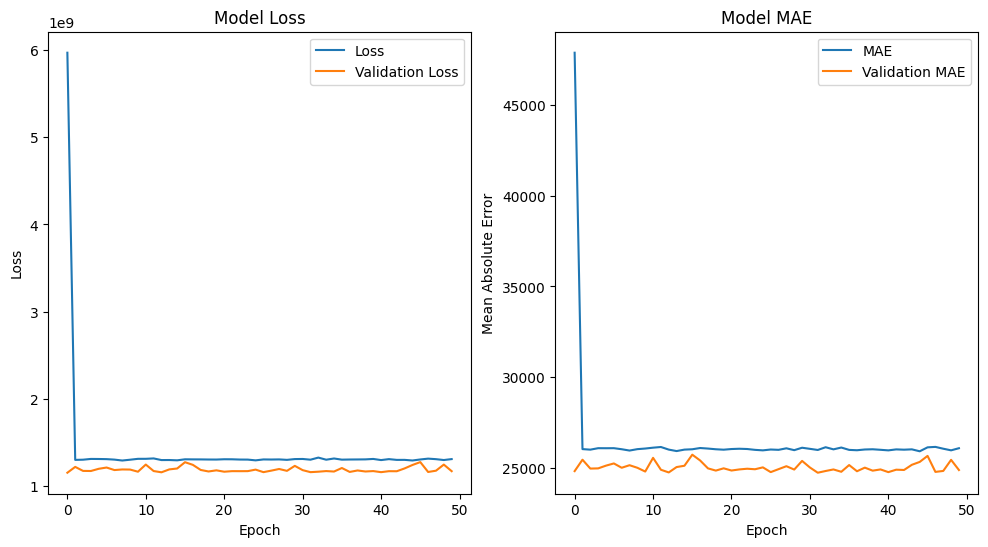

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Preprocess data for deep learning
# Standardize numerical features

# Define the neural network model
def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Initialize and train the model
model = build_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predict
y_pred_dl = model.predict(X_test)

# Evaluate the model
r2_dl = r2_score(y_test, y_pred_dl)
rmse_dl = np.sqrt(mean_squared_error(y_test, y_pred_dl))

print(f"Deep Learning Model R-Squared: {r2_dl:.4f}")
print(f"Deep Learning Model RMSE: {rmse_dl:.2f}")

# Plot training history (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()
